In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Set up your OpenAI API key (replace with your key or use environment variable)


In [2]:
from os import getenv

# Initialize the language model
llm = ChatOpenAI(
  model="anthropic/claude-sonnet-4",
  temperature=0.2,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY")
  )

In [3]:
@tool
def execute_python_code(code: str) -> str:
    """
    Execute Python code safely using eval.
    
    Args:
        code: Python code to execute (simple expressions only)
    
    Returns:
        String containing the result of the code execution
    """
    try:
        # Basic safety: only allow simple expressions
        if any(keyword in code.lower() for keyword in ['import', 'exec', '__', 'open', 'file']):
            return "Error: Code contains potentially unsafe operations"
        
        # Execute the code using eval
        result = eval(code)
        return f"Result: {result}"
    except Exception as e:
        return f"Error executing code: {str(e)}"

In [4]:
# Create the React agent with our single tool
memory = MemorySaver()
agent = create_react_agent(
    llm, 
    tools=[execute_python_code],
    checkpointer=memory
)

# Test the agent
config = {"configurable": {"thread_id": "simple-math"}}

print("🤖 Simple React Agent with Python Code Execution\n")

# Test 1: Simple math
result = agent.invoke(
    {"messages": [HumanMessage(content="What is 25 * 37 + 100?")]},
    config=config
)

print("Math calculation:")
for i, msg in enumerate(result["messages"]):
    # Print message type for clarity
    print(f"[{type(msg).__name__}]")
    # If the message is an AIMessage with tool calls, print tool call details
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        for tool_call in msg.tool_calls:
            print(f"  [TOOL CALL] name: {tool_call['name']}, args: {tool_call['args']}, id: {tool_call['id']}")
    # If the message is a ToolMessage, print which tool and the result
    if hasattr(msg, "name") and hasattr(msg, "content"):
        if getattr(msg, "name", None):
            print(f"  [TOOL RESULT] {msg.name}: {msg.content}")
        else:
            print(msg.content)
    else:
        print(msg.content)
print("\n" + "="*50 + "\n")

🤖 Simple React Agent with Python Code Execution

Math calculation:
[HumanMessage]
What is 25 * 37 + 100?
[AIMessage]
  [TOOL CALL] name: execute_python_code, args: {'code': '25 * 37 + 100'}, id: toolu_01BKRy2Fi3WHk3ZYG69LMb7r
I'll calculate that for you.
[ToolMessage]
  [TOOL RESULT] execute_python_code: Result: 1025
[AIMessage]
The answer is 1025.

To break it down:
- 25 × 37 = 925
- 925 + 100 = 1025




In [19]:
@tool
def get_weather(city: str) -> str:
    """
    Get the weather for a given city.
    """
    return f"The weather in {city} is sunny and 68°F."


second_react_agent = create_react_agent(
    llm, 
    tools=[get_weather],
    checkpointer=memory
)

second_react_agent.invoke(
    {"messages": [HumanMessage(content="What is 25 * 37 + 100?")]},
    config={"configurable": {"thread_id": "simple-math-2"}}
)

{'messages': [HumanMessage(content='What is 25 * 37 + 100?', additional_kwargs={}, response_metadata={}, id='f26df2f1-f12c-49a1-862c-2963a7807d20'),
  AIMessage(content="I can help you calculate that! Let me work through this step by step:\n\n25 × 37 + 100\n\nFirst, I'll multiply 25 × 37:\n25 × 37 = 925\n\nThen I'll add 100:\n925 + 100 = 1,025\n\nTherefore, 25 × 37 + 100 = 1,025", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 388, 'total_tokens': 479, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'anthropic/claude-sonnet-4', 'system_fingerprint': None, 'id': 'gen-1752340456-dki1qLOugHhhk6vAMgvE', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--d04c6e63-542e-4686-a939-0f385c62d216-0', usage_metadata={'input_tokens': 388, 'output_tokens': 91, 'total_tokens': 479, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='What is 25 * 37 +

# Multi-Agent Network

In [ ]:
from langchain.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

# Define a tool for agent1 that represents a handoff to agent2
@tool  
def handoff_to_agent2(message: str) -> str:
    """
    Handoff to agent2 with a message.
    Use this tool when you need agent2 to help with weather-related queries.
    """
    return f"Transferred to agent2: {message}"

# Define a tool for agent2 that represents a handoff to agent1  
@tool
def handoff_to_agent1(message: str) -> str:
    """
    Handoff to agent1 with a message.
    Use this tool when you need agent1 to help with code execution or mathematical calculations.
    """
    return f"Transferred to agent1: {message}"

system_prompt_agent_1 = """
You are Agent 1, a helpful assistant that can handoff to other agents. You can execute python code.

The agents are:
- Agent 1 (you) who can execute python code
- Agent 2 who can get the weather in any city in real time

If you need another agent to help you, you can handoff to them using the appropriate handoff tool.
"""

system_prompt_agent_2 = """
You are Agent 2, a helpful assistant that can handoff to other agents. You can get the weather in any city in real time.

The agents are:
- Agent 1 who can execute python code
- Agent 2 (you) who can get the weather in any city in real time

If you need another agent to help you, you can handoff to them using the appropriate handoff tool.
"""

agent1 = create_react_agent(
    llm,
    prompt=system_prompt_agent_1,
    tools=[handoff_to_agent2, execute_python_code],
    checkpointer=memory
)

agent2 = create_react_agent(
    llm,
    prompt=system_prompt_agent_2,
    tools=[handoff_to_agent1, get_weather],
    checkpointer=memory
)


📊 Conversation Graph Visualization:


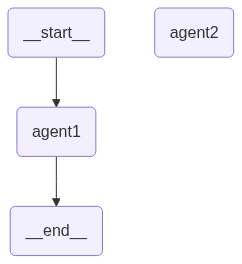

In [26]:
# Example of a multi-agent workflow using LangGraph's Command-based handoff pattern

from typing import Literal, Annotated, TypedDict
from langgraph.types import Command
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Define the state for the conversation (shared message list)
class ConversationState(TypedDict):
    messages: Annotated[list, add_messages]

def agent1_node(state: ConversationState):
    """Agent 1 can execute Python code and handoff to agent 2"""
    num_message_in_state = len(state["messages"])
    # print("PRINTING STATE MESSAGES IN AGENT 1")
    # for msg in state["messages"]:
    #     print(msg)
    # print("PRINTING STATE MESSAGES IN AGENT 1 DONE")
    response = agent1.invoke({"messages": state["messages"]})
    # print("PRINTING RESPONSE IN AGENT 1")
    # for msg in response["messages"][num_message_in_state:]:
    #     print(msg)
    # print("PRINTING RESPONSE IN AGENT 1 DONE")
    
    # Check if any handoff tools were called
    for idx, message in enumerate(response["messages"][num_message_in_state:]):
        if hasattr(message, 'tool_calls') and message.tool_calls:
            for tool_call in message.tool_calls:
                if tool_call.get('name') == 'handoff_to_agent2':
                    # Route to agent2
                    tool_call_id = tool_call.get('id')
                    tool_result_message = ToolMessage(
                        content=f"Successfully transferred to agent2",
                        tool_call_id=tool_call_id
                    )
                    return Command(
                        goto="agent2",
                        update={"messages": [*response["messages"][num_message_in_state:num_message_in_state + idx], message, tool_result_message]}  # Only pass everything before the handoff and the handoff message and the tool result message
                    )
    
    # No handoff needed, end the conversation
    return {"messages": response["messages"]}

def agent2_node(state: ConversationState):
    """Agent 2 can get weather and handoff to agent 1"""
    num_message_in_state = len(state["messages"])
    # print("PRINTING STATE MESSAGES IN AGENT 2")
    # for msg in state["messages"]:
    #     print(msg)
    # print("PRINTING STATE MESSAGES IN AGENT 2 DONE")
    response = agent2.invoke({"messages": state["messages"]})
    # print("PRINTING RESPONSE IN AGENT 2")
    # for msg in response["messages"][num_message_in_state:]:
    #     print(msg)
    # print("PRINTING RESPONSE IN AGENT 2 DONE")
    # Check if any handoff tools were called
    for idx, message in enumerate(response["messages"][num_message_in_state:]):
        if hasattr(message, 'tool_calls') and message.tool_calls:
            for tool_call in message.tool_calls:
                if tool_call.get('name') == 'handoff_to_agent1':
                    # Route to agent1
                    tool_call_id = tool_call.get('id')
                    tool_result_message = ToolMessage(
                        content=f"Successfully transferred to agent1",
                        tool_call_id=tool_call_id
                    )
                    return Command(
                        goto="agent1",
                        update={"messages": [*response["messages"][num_message_in_state:num_message_in_state + idx], message, tool_result_message]}  # Only pass everything before the handoff and the handoff message and the tool result message
                    )
    
    # No handoff needed, end the conversation
    return {"messages": response["messages"]}

# Build the graph
graph = StateGraph(ConversationState)
graph.add_node("agent1", agent1_node)
graph.add_node("agent2", agent2_node)

# Set the entry point
graph.set_entry_point("agent1")

# Compile the graph
conversation_graph = graph.compile()

# Try to visualize the conversation graph using IPython display, similar to the deep_research example
try:
    from IPython.display import Image, display

    png_bytes = conversation_graph.get_graph().draw_mermaid_png()

    with open("conversation_graph.png", "wb") as f:
        f.write(png_bytes)

    print("📊 Conversation Graph Visualization:")
    display(Image("conversation_graph.png"))
except Exception as e:
    print("Could not visualize the conversation graph:", e)


In [33]:
import uuid
import time

# Example usage: start a conversation and stream events
print("🤖 Multi-Agent Network with Command-based Tool Handoffs\n")

initial_message = "Whats is the temperature in Paris times 1243435"

initial_state = {"messages": [HumanMessage(content=initial_message)]}
initial_state

# Stream the conversation
stream = conversation_graph.stream(
    initial_state, 
    config={
        "recursion_limit": 10, 
        "configurable": {"thread_id": f'{str(uuid.uuid4())}-{time.time()}'}
    }
)

print("📝 Conversation Flow:")
print(f'🧑‍💬 Human: {initial_message}')
for event in stream:
    # Print the agent and its latest message, and also show tool calls if present
    for agent_name, agent_response in event.items():
        if "messages" in agent_response:
            last_message = agent_response["messages"][-1]
            print(f"\n🤖 {agent_name.upper()}: {last_message.content}")
            # Print tool calls if present in the last message
            if hasattr(last_message, "tool_calls") and getattr(last_message, "tool_calls", None):
                for tool_call in last_message.tool_calls:
                    print(f"    🛠️ [TOOL CALL] 🏷️: {tool_call.get('name')}, 📝: {tool_call.get('args')}, 🆔: {tool_call.get('id')}")

print("\n✅ Conversation completed!")

🤖 Multi-Agent Network with Command-based Tool Handoffs

📝 Conversation Flow:
🧑‍💬 Human: Whats is the temperature in Paris times 1243435

🤖 AGENT1: Successfully transferred to agent2

🤖 AGENT2: Successfully transferred to agent1

🤖 AGENT1: The current temperature in Paris is 68°F, and when multiplied by 1243435, the result is **84,553,580**.

✅ Conversation completed!


In [34]:
list(event.keys())

['agent1']

In [35]:
event[list(event.keys())[0]]['messages']

[HumanMessage(content='Whats is the temperature in Paris times 1243435', additional_kwargs={}, response_metadata={}, id='74728fd6-6f0f-498b-a37f-fb321d6706c4'),
 AIMessage(content="I'll help you get the temperature in Paris and then multiply it by 1243435. Let me first get the current temperature in Paris by handing off to Agent 2.", additional_kwargs={'tool_calls': [{'id': 'toolu_01HS3wFrci9d4EG4nkefS5nL', 'function': {'arguments': '{"message": "Please get the current temperature in Paris"}', 'name': 'handoff_to_agent2'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 589, 'total_tokens': 690, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'anthropic/claude-sonnet-4', 'system_fingerprint': None, 'id': 'gen-1752340920-C4RHzQfDaOozwCy6KkTo', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dbec40ed-b8db-44d2-b26c-7a93bea815c1-0', tool_calls

In [36]:
# Print all messages from agent2 in a readable way, using emojis for clarity
last_agent_called = list(event.keys())[0]
for i, msg in enumerate(event[last_agent_called]["messages"]):
    print(f"  📨 [{type(msg).__name__}]")
    # If the message is an AIMessage with tool calls, print tool call details with emojis
    if hasattr(msg, "tool_calls") and getattr(msg, "tool_calls", None):
        for tool_call in msg.tool_calls:
            print(f"    🛠️ [TOOL CALL] 🏷️: {tool_call['name']}, 📝: {tool_call['args']}, 🆔: {tool_call['id']}")
    # If the message is a ToolMessage, print which tool and the result with emojis
    if hasattr(msg, "name") and hasattr(msg, "content") and msg.content:
        if getattr(msg, "name", None):
            print(f"    ✅ [TOOL RESULT] {msg.name}: {msg.content}")
        else:
            print(f"    💬 [MESSAGE] {msg.content}")
    elif msg.content:
        print(f"    💬 [MESSAGE] {msg.content}")


  📨 [HumanMessage]
    💬 [MESSAGE] Whats is the temperature in Paris times 1243435
  📨 [AIMessage]
    🛠️ [TOOL CALL] 🏷️: handoff_to_agent2, 📝: {'message': 'Please get the current temperature in Paris'}, 🆔: toolu_01HS3wFrci9d4EG4nkefS5nL
    💬 [MESSAGE] I'll help you get the temperature in Paris and then multiply it by 1243435. Let me first get the current temperature in Paris by handing off to Agent 2.
  📨 [ToolMessage]
    💬 [MESSAGE] Successfully transferred to agent2
  📨 [AIMessage]
    🛠️ [TOOL CALL] 🏷️: get_weather, 📝: {'city': 'Paris'}, 🆔: toolu_01CetGD8z7VFSAfvREi7YWUy
    💬 [MESSAGE] Wait, I am Agent 2! Let me get the weather in Paris first:
  📨 [ToolMessage]
    ✅ [TOOL RESULT] get_weather: The weather in Paris is sunny and 68°F.
  📨 [AIMessage]
    🛠️ [TOOL CALL] 🏷️: handoff_to_agent1, 📝: {'message': 'Please calculate 68 times 1243435. The temperature in Paris is currently 68°F and I need to multiply it by 1243435.'}, 🆔: toolu_01YQqA1AGm3eFJi9CMMXWiUJ
    💬 [MESSAGE] Now I n